In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import line_search
from tensorflow.python import tf2
from keras.datasets import mnist

## Forward-Backward
We will use FB to minimize the function
$$f(x) + g(x) = \frac{1}{2 \lambda}\|Ax-y\|_2^2 + \|x\|_1$$
Let us for the time being omit the $\frac{1}{2\lambda}$ term. For the Forward-Backward method, we require $\nabla f$.
We can find this using directional derivatives. Rewriting, we have
$$f(x) = \|Ax-y\|_2^2 = (Ax-y)^T(Ax-y) = x^TA^TAx - 2x^TA^Ty + y^Ty.$$
The directional derivative of $f$ along $v$ is
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h}$$
$$= \lim_{h \xrightarrow{} 0} \frac{(x+hv)^TA^TA(x+hv) - 2(x+hv)^TA^Ty + y^Ty - x^TA^TAx + 2x^TA^Ty - y^Ty}{h}$$
$$
= \lim_{h \xrightarrow{} 0} 2x^TA^tAv + hv^TA^TAv - 2v^TA^Ty = v^T(2A^TAx - 2A^Ty).
$$
However, from Taylor expansion we also have
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h} \approx \lim_{h \xrightarrow{} 0} \frac{f(x) + hv^T\nabla f(x) - f(x)}{h} = v^T \nabla f(x).$$
Hence from the previous equation we also have
$$\nabla_v f(x) = v^T(2A^TAx - 2A^Ty) = v^T \nabla f(x),$$
and so
$$\nabla f(x) = 2A^TAx - 2A^Ty.$$
Now, the Forward-Backward Algorithm is given to us as
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla f(x_n)\right).$$
In the case that $R(x) = \|x\|_1$, we have
$$prox_{\gamma R}(x) = sign(x) \max{(|x|-\gamma,0)}.$$
Hence, for our current loss function, we have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{\lambda}\left(A^TAx - A^Ty\right)\right),$$
with $prox$ as above.

In [8]:
def errL2(A,x,y):   #Return L2 error of Ax-y
    dif = A@x - y
    return dif.T @ dif

In [9]:
def funcreg(A,x,y,lam):    #Return f(x)+g(x)
    dif = A@x - y
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx

In [10]:
#Implement thresh/prox function for g(x) = ||1||_1
def prox(x,omg): 
    return np.sign(x) * np.maximum(np.abs(x)-omg,0)

features = 10;
samples = 30;
A = np.random.randn(features,samples)
#Try different matrices
y = np.random.randn(features)
lam = .9 * np.max( A.T @ y )

In [39]:
def GradF(A,x,y,lam):
    return (((A.T @ A) @ x) - A.T @ y)

Final f(x)+g(x): 0.9474949433004485
Final soln: [-0.         -0.01965947  0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.
  0.          0.         -0.          0.06694375  0.          0.
 -0.          0.          0.         -0.          0.          0.        ]


Text(0.5, 1.0, 'ln(f(x)+g(x))')

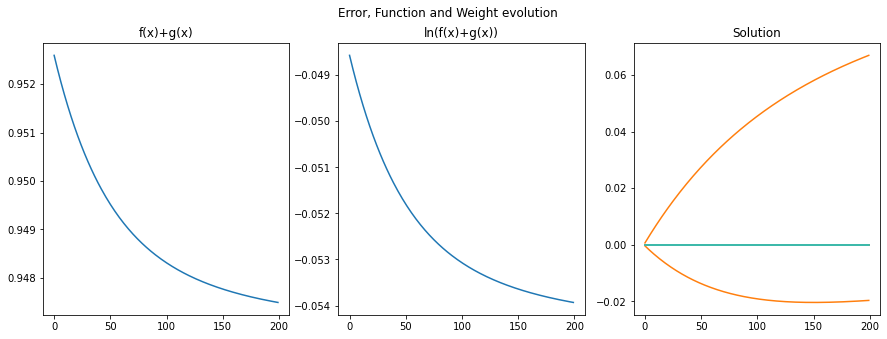

In [97]:
#Implement Forward Backward alg
#initialize x_0 = 0
x = np.zeros(samples)
niter = 200
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
for i in range(niter):
    x = prox(x - (omg/lam)*(np.dot(np.matmul(A.T,A),x) - np.dot(A.T,y)),omg)
    xtemp[:,i] = x
    errvec[i] = errL2(A,x,y)
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs[0].plot(funcvec.T);
axs[0].set_title('f(x)+g(x)')
axs[2].plot(xtemp.T);
axs[2].set_title('Solution')
axs[1].plot(np.log(funcvec.T));
axs[1].set_title('ln(f(x)+g(x))')

## Gradient Descent
Now, by Theorem 2 in the paper, we have that $(\mathcal{P}_\lambda)$ is equivalent to
$$\min_{v \in \mathbb{R}^k} f(v) \triangleq \min_{u \in \mathbb{R}^n} G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right).$$

We will use $h(v \odot v) = \|v\|_2^2$ and $L$ as above. By Corollary 1, $u$ solves
$$(diag(v) X^TX diag(v) + \lambda I)u = v \odot_{\mathcal{G}} (X^Ty),$$
so that
$$u = (diag(v) X^TX diag(v) + \lambda I)^{-1} (v \odot_{\mathcal{G}} (X^Ty)).$$

In order to solve $\min_{v \in \mathbb{R}^k} f(v)$ by Gradient Descent, we find $\nabla f = \frac{\partial f}{\partial v}:$
$$\frac{\partial f}{\partial v} = \partial_v G(u,v) = v + \frac{1}{\lambda} \partial_v L.$$ Now, using chain rule, we have that, denoting $\omega = (v \odot_{\mathcal{G}} u),$
$$\frac{\partial L}{\partial v_i} = \nabla L \cdot \frac{\partial \omega}{\partial v_i},$$
that is
$$\frac{\partial L}{\partial v_i} = \frac{1}{\lambda}\left(X^TX (v \odot_{\mathcal{G}} u) - X^Ty \right) \cdot u',$$
where $u' = (0, \ldots, u_g, \ldots, 0)$. The above can also be reformulated (as per Proposition 3) as
$$\nabla f = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right)$$
We can now apply Gradient Descent.

In [13]:
def find_u(X,y,v,lam): 
    invm =  np.diag(v) @ (X.T @ (X @ np.diag(v))) + lam * np.eye(np.size(v))
    return np.linalg.inv(invm) @ (np.multiply(v,X.T @ y))

In [14]:
def Gradf(X,y,v,lam):
    u = find_u(X,y,v,lam)
    tempvec = v + (1/lam) * ( u * (X.T @ (X @ (v*u)) - X.T @ y))
    return tempvec

Final f(x)+g(x): 0.9472731976340762
Final soln: [-1.95026087e-09 -1.41417531e-02  2.07304513e-10  2.20216757e-05
 -2.23650638e-07 -1.14659263e-07 -2.20325029e-09 -1.62826994e-08
 -1.06208633e-10  4.70689251e-11 -1.47054754e-09 -6.05764033e-04
 -6.90542922e-09  1.57996646e-09 -1.83652965e-11  2.67362437e-12
  1.39208927e-04 -9.65383441e-05  4.04133643e-08  1.64029331e-08
 -7.13609162e-10  8.99694838e-02  8.27912746e-10  3.73724228e-11
 -2.30882294e-06  2.78553166e-04  3.09170945e-12 -2.62226672e-06
  3.13178138e-04  1.94573449e-07]


Text(0.5, 1.0, 'Solution')

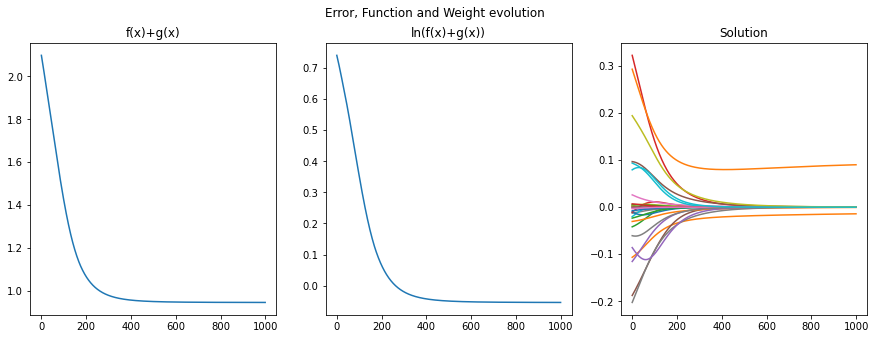

In [66]:
step = 0.01
niter = 1000
errvec2 = np.zeros(niter)
funcvec2 = np.zeros(niter)
v = np.random.randn(samples)
#v = np.zeros(samples)
xtemp2 = np.zeros((samples,niter))
for i in range(niter):
    grad = Gradf(A,y,v,lam)
    v = v - step*grad
    x = v * find_u(A,y,v,lam)
    xtemp2[:,i] = x
    errvec2[i] = errL2(A,x,y)
    funcvec2[i] = funcreg(A,x,y,lam)
    
print("Final f(x)+g(x):", funcvec2[-1])
print("Final soln:", x)

fig, axs2 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs2[1].plot(np.log(funcvec2.T));
axs2[1].set_title('ln(f(x)+g(x))')
axs2[0].plot(funcvec2.T);
axs2[0].set_title('f(x)+g(x)')
axs2[2].plot(xtemp2.T);
axs2[2].set_title('Solution')
    


## Gradient Descent on $u$ and $v$

Now we will compare convergence when using the SGD algorithm, as opposed to Gradient Descent.

Recall from above that if
$$G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right) = \frac{1}{2}\|v\|_2^2 + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right),$$ 
with L the square-loss function, then we have
$$\partial_v G(u,v) = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$
Similarly, we have
$$\partial_u G(u,v) = u + \frac{1}{\lambda} \left( v \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$

Now our update step will look like
$$\begin{cases}
u_{k+1} = u_k - \gamma_k\partial_u G(u,v) \\
v_{k+1} = v_k - \gamma_k\partial_v G(u,v)
\end{cases}$$

Regarding which stepsize, $\omega_k$, to use: we can either update $\omega_k$ using Backtracking Line Search or using the Barzilai-Borwein algorithm.

[1]Gabriel Peyré. Mathematical Foundations of Data Sciences, 2021.

In [16]:
def Gux(u,v,X,y,lam):             #Our objective function G(u,v)
    dif = X@(u * v) - y
    return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)

In [17]:
def GnabV(u,v,X,y,lam):
    return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)

In [18]:
def GnabU(u,v,X,y,lam):
    return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)

In [19]:
def LineSearchU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

In [20]:
def LineSearchV(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for v minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabV(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux(u,(v - omg*grad),X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

Final f(x)+g(x): 1.018316874108583
Final soln: [ 2.29614315e-04 -5.03042520e-02 -3.90202366e-03  3.62979744e-04
 -1.66372707e-02 -6.59188443e-03  2.22442383e-05  1.64934504e-04
 -6.85264052e-04 -3.02076525e-03 -1.04080483e-03 -1.85888870e-02
 -2.80665974e-03  2.73239893e-03 -1.24741831e-04  2.91616566e-03
  1.34588695e-02 -2.10423328e-02  9.77032564e-03  1.02448717e-03
 -6.44912001e-03  1.60496717e-01  6.92351826e-03 -1.03020076e-03
 -5.68055184e-04  8.00896569e-05  1.06155471e-03 -8.99164991e-04
  2.33550658e-02  9.70164042e-03]


Text(0.5, 1.0, 'Stepsize')

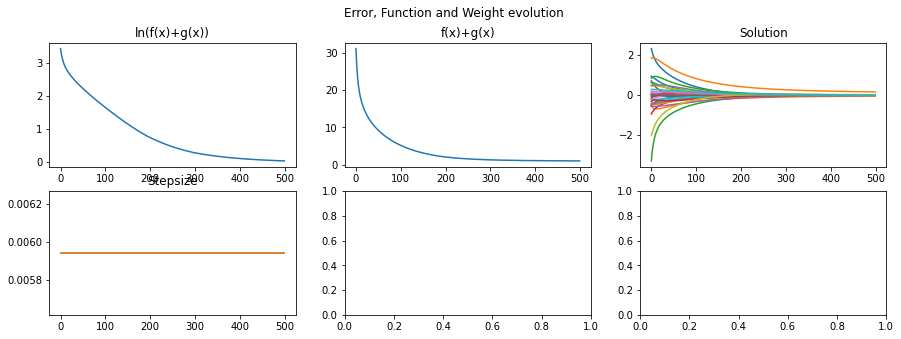

In [95]:
#Do gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 500
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
print("Final soln:", x)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [87]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / abs((st.T @ yt))

In [23]:
a = np.arange(1,26)
a = a.reshape(5,5)
print(a)
k = np.array([[1,0,0],[0,1,0],[0,0,1]])
ndimage.convolve(a, k, mode='constant', cval=0.0)

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]]


array([[ 8, 10, 12, 14,  5],
       [18, 21, 24, 27, 14],
       [28, 36, 39, 42, 24],
       [38, 51, 54, 57, 34],
       [21, 38, 40, 42, 44]])

Final error: 0.9492381679432439
Final soln: [-9.78447776e-20 -3.50112595e-02  1.59458493e-31  7.40893669e-07
 -5.68260381e-10 -3.16043097e-20 -2.41605273e-15 -3.88412637e-17
 -7.83375622e-27  1.11027265e-29 -1.98607207e-21 -1.23575200e-06
 -9.81460736e-18  5.62151868e-23 -2.02917311e-23  1.17832395e-12
  3.80713807e-05 -1.36505363e-05  5.21159514e-16  8.81792703e-21
 -2.48212272e-18  2.79286579e-02  6.68117202e-21  9.48983986e-30
 -2.17742587e-10  7.85997934e-05  2.50512602e-40 -1.19691820e-07
  5.33827650e-06  1.96695737e-17]


Text(0.5, 1.0, 'Stepsize')

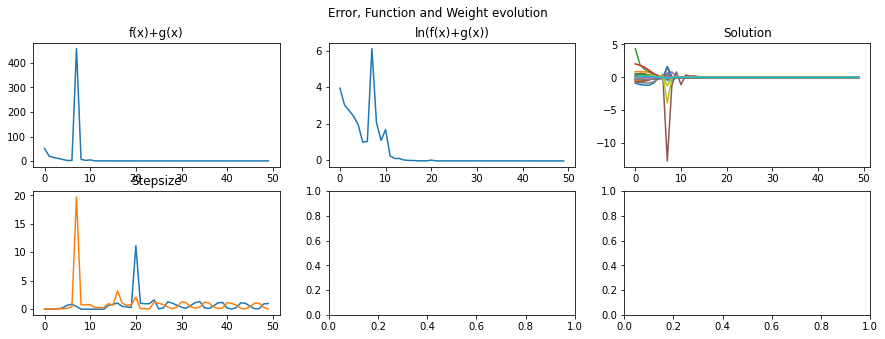

In [96]:
#Do gradient descent with step chosen using Barzilai-Borwein
step = 0.001
niter = 50
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    #stepu = LineSearchU(u,v,ch_sample,y,lam)
    #stepv = LineSearchV(u,v,ch_sample,y,lam)
    stepu = .1/np.linalg.norm(A)
    stepv = .1/np.linalg.norm(A)
    if(i > 0):
        stepu = BBstep(u,uold,GnabU(u,v,A,y,lam),GnabU(uold,vold,A,y,lam))
        stepv = BBstep(v,vold,GnabV(u,v,A,y,lam),GnabV(uold,vold,A,y,lam))
    
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    uold = u
    vold = v
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final error:", funcvec3[-1])
print("Final soln:", x)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec3.T));
axs3[0,1].set_title('ln(f(x)+g(x))')
axs3[0,0].plot(funcvec3.T);
axs3[0,0].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [60]:
#Now try with real data - load MNIST digits
(train_X, train_y), (test_X, test_y) = mnist.load_data()

Now, note that
$$\frac{1}{2}\|Ax-y\|_2^2 = \frac{1}{2}\sum^m_{i=1} \left(\langle A_i, x \rangle - y_i \right)^2 = \frac{1}{2}\sum^m_{i=1} Q_i = \frac{1}{2}\sum^m_{i=1} L_i^2 $$

Thus, a partial derivative w.r.t $x_i$ is just
$$\nabla Q_i(x) = L_i \cdot A_i^T,$$

where $A_i$ is the $i$-th row of the matrix $A$, corresponding to the $i$-th sample.

Furrthermore, if we have that $x = u \odot v,$ then by chain rule we have
$$\nabla_u Q_i(x) = L_i \cdot A_i^T \odot v.$$
$$\nabla_v Q_i(x) = L_i \cdot A_i^T \odot u.$$

In [55]:
def SGnabV(u,v,X,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    Li = Xi @ (u*v) - y[indx]
    return v + (1/lam)*Li*(Xi.T @ u)

In [56]:
def SGnabU(u,v,X,y,lam,indx):             #Stochastic Gradient for U
    Xi = X[indx,:]
    Li = Xi @ (u*v) - y[indx]
    return u + (1/lam)*Li*(Xi.T @ v)

Final f(x)+g(x): 0.95268964913472
Final soln: [-1.90403684e-55 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55
 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55
 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55
 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55
 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55
 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55
 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55 -1.90403684e-55
 -1.90403684e-55 -1.90403684e-55]


Text(0.5, 1.0, 'Stepsize')

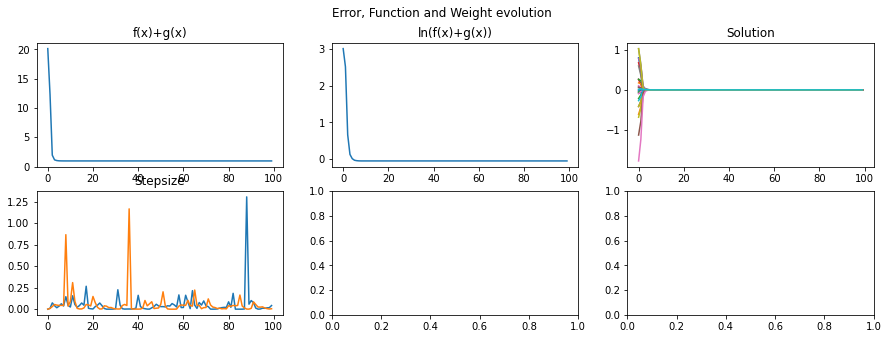

In [93]:
#Do stochastic gradient descent with step chosen using Barzilai-Borwein (SGD-BB)
step = 0.001
niter = 100
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp = np.zeros((samples,niter))
funcvec = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_sz = 20
epoch_u = 0
epoch_v = 0
beta = 0.5
for i in range(niter):

    
    if(i > 0):
        #stepu = (1/m) * BBstep(u,uold,gradu,SGnabU(uold,vold,A,y,lam,rndindx))
        #stepv = (1/m) * BBstep(v,vold,gradv,SGnabV(uold,vold,A,y,lam,rndindx))
        stepu = (1/epoch_sz) * BBstep(u,uold,gradu_avg,gradu_avg_old)
        stepv = (1/epoch_sz) * BBstep(v,vold,gradv_avg,gradv_avg_old)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
    
    uold = u
    vold = v
    if (i == 0):
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        gradu_avg = 0
        gradv_avg = 0
    gradu_avg_old = gradu_avg
    gradv_avg_old = gradv_avg
    gradu_avg = 0
    gradv_avg = 0
    for t in range(epoch_sz):
        rndindx = np.random.randint(0, features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        u = u - stepu * gradu
        v = v - stepv * gradv
        gradu_avg = beta * gradu + (1-beta) * gradu_avg
        gradv_avg = beta * gradv + (1-beta) * gradv_avg
    
    xtemp[:,i] = u * v
    funcvec[i] = funcreg(A,(u * v),y,lam)
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", u * v)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec.T));
axs3[0,1].set_title('ln(f(x)+g(x))')
axs3[0,0].plot(funcvec.T);
axs3[0,0].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

Final f(x)+g(x): 0.9628004293670914
Final soln: [-1.15782098e-04 -7.37866442e-05  1.38266472e-05 -1.20596398e-03
 -4.38287557e-04  1.42882535e-05 -7.04159197e-04  3.12541371e-04
 -3.84947935e-05  3.03561674e-05  1.89859325e-04 -1.53875659e-04
 -1.33674734e-03  6.96002821e-04  5.14578547e-04 -4.52600185e-04
  1.87245687e-03 -7.60024328e-04 -3.35289127e-04  3.23493762e-04
 -6.07497205e-05  9.15840354e-04  5.94080281e-05 -1.66438922e-03
 -3.68025389e-04 -1.66764088e-05  6.28497314e-04 -3.82374658e-04
  1.18125619e-03  3.47873747e-04]


Text(0.5, 1.0, 'Stepsize')

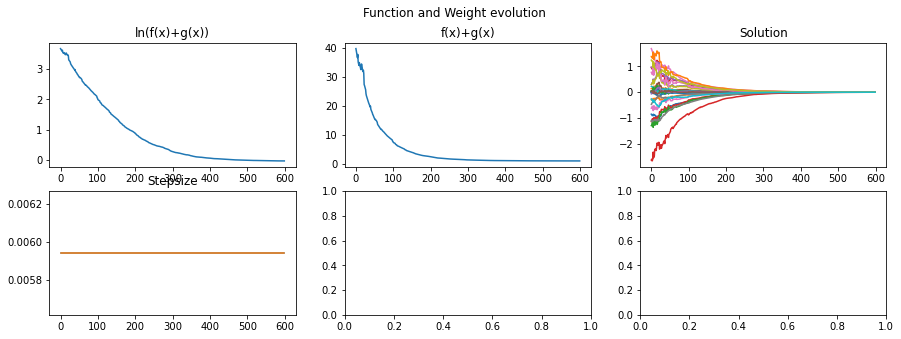

In [98]:
#Do stochastic gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 600
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    rndindx = np.random.randint(0, features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
print("Final soln:", x)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# Stochastic Forward-Backward

We modify the F-B algorithm to work with SGD, rather than batch descent.

We have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla_{i} f(x_n)\right).$$
That is,
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{\lambda}L_i \cdot A_i^T\right),$$
with $prox$ as above.

In [29]:
def SGnabX(X,x,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    Li = Xi @ x - y[indx]
    return(1/lam)*Li*Xi.T

Final f(x)+g(x): 0.95268964913472
Final soln: [-0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.
 -0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0.]


Text(0.5, 1.0, 'ln(f(x)+g(x))')

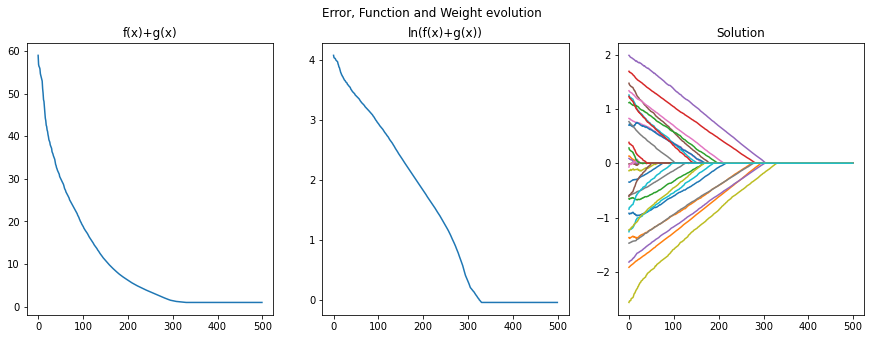

In [30]:
#Implement SGD Forward Backward alg
#initialize x_0 = 0
x = np.random.randn(samples)
niter = 500
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
for i in range(niter):
    rndindx = np.random.randint(0, features)
    x = prox(x - omg *SGnabX(A,x,y,lam,rndindx),omg)
    xtemp[:,i] = x
    #errvec[i] = errL2(A,x,y)
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)

fig, axs4 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs4[0].plot(funcvec.T);
axs4[0].set_title('f(x)+g(x)')
axs4[2].plot(xtemp.T);
axs4[2].set_title('Solution')
axs4[1].plot(np.log(funcvec.T));
axs4[1].set_title('ln(f(x)+g(x))')

# Dual Averaging Method

In [100]:
def RDAstep(gt,t,lam,rho):
    lRDA = lam + rho/np.sqrt(t)
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lRDA:
            x[i] = 0
        else:
            x[i] = -np.sqrt(t) * (gt[i] - lRDA*np.sign(gt[i]))
            
    return x

In [101]:
def avgsubg(gt,gtm1,t):
    return ((t-1)/t) * gtm1 + (1/t) * gt

Final f(x)+g(x): 3.075744112681655e+93
Final soln: [-1.78864557e+45 -5.17293915e+43 -2.27599316e+45 -3.57509237e+45
  4.41143244e+45 -4.85092771e+45  6.19064608e+45 -2.07412082e+45
 -1.78501293e+45 -6.81302709e+45  6.72847687e+45 -4.06907479e+45
  4.24182582e+45 -3.64449142e+45 -2.79335296e+45 -4.79085081e+45
  2.39176376e+44  7.62633358e+44  6.06229336e+45  1.54705844e+45
 -2.19230674e+45 -2.01593453e+45  8.73149851e+44 -1.15006773e+45
  2.34995864e+45  7.00752216e+45 -1.23554564e+45  1.21499920e+45
  2.66604878e+45  3.60197347e+45]


<ipython-input-102-6eb403daf280>:29: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec.T));


Text(0.5, 1.0, 'ln(f(x)+g(x))')

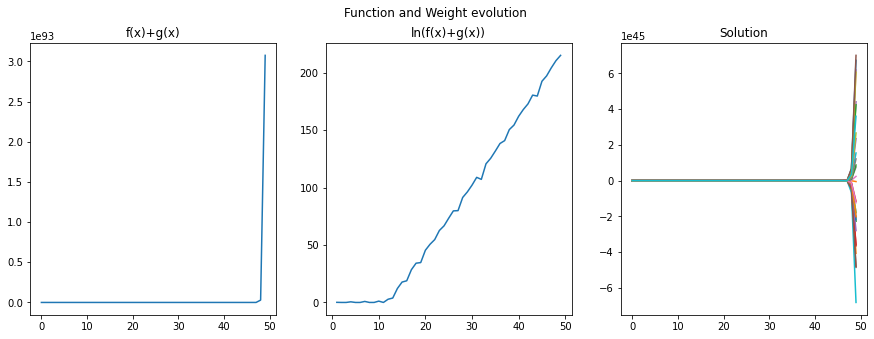

In [102]:
#Incorporate the RDA method as defined in paper by Lin Xiao
x = np.zeros(samples)
gt = np.zeros(samples)
niter = 50
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
rho = 0.1

for i in range(1,niter):
    gtm1 = gt
    gt = GradF(A,x,y,lam)
    gtavg = avgsubg(gt,gtm1,i)
    x = RDAstep(gtavg,i,lam,rho)
    xtemp[:,i] = x
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)

fig, axs5 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(funcvec.T);
axs5[0].set_title('f(x)+g(x)')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec.T));
axs5[1].set_title('ln(f(x)+g(x))')

In [86]:
abs(-5)

5